<a href="https://colab.research.google.com/github/alex-jk/painting-lora-finetune/blob/main/neural_style_transfer_photos_to_paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set before importing torch; then Runtime -> Restart runtime
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [16]:
from google.colab import drive
drive.mount('/content/drive')

CONTENT = "/content/drive/MyDrive/nst/images/content.jpg"
STYLE   = "/content/drive/MyDrive/nst/images/style.jpg"

# Option to load generated images from Google Drive
generated_out_path = "/content/drive/MyDrive/nst/images/out.png"
generated_out_painterly_path = "/content/drive/MyDrive/nst/images/out_painterly.png"

get_generated_images_from_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h3><font color="#0b3d91">Neural Style Transfer Method</font></h3>

**Goal**

Turn your photo into a painting-like image without moving objects: keep the photo’s layout, borrow the painting’s colors/texture.

**How it works (high level)**<br>
We create an output image `X` and optimize its pixels so that:<br>
• its **deep features** (from a CNN) match the photo → preserves structure/content;<br>
• its **feature statistics** (Gram matrices) match the painting → transfers style/brushwork.

**VGG-19**<br>
**VGG-19** is a classic **convolutional neural network (CNN)** trained on `ImageNet`. It stacks many conv layers that detect edges, textures, parts, and objects.<br>
• **Shallow layers** respond to color/texture; **deep layers** to object/layout.<br>
• Freeze VGG (no training) and use it only to extract features that act as "perceptual rulers."<br>
• To preserve the photo's content, we match its core VGG features. To inject the painting's style, we match its Gram stats, which are a statistical measurement of which textures and patterns (like certain brushstrokes and colors) tend to appear together throughout the image.

<h3><font color="#0b3d91">How the neural style transfer model is trained (fast/feed-forward version)</font></h3>

**Notation**
- `f_phi`: trainable **stylizer** `CNN` (the only network you update)
- `VGG`: frozen **loss network** (used only to compute losses)
- `C`: content image, `S`: style image
- `X = f_phi(C)`: stylized output

**Training loop**
1. **Freeze VGG.** Use it only to extract features for the losses (no weight updates).
2. **Choose a style** image `S` (or sample from a style set).
3. **For each content image `C`:**
    - **Forward Pass:** We feed the content photo `C` through our trainable stylizer CNN `f_phi` to produce a candidate image `X`. This network is the one we are actively training, and its output is our `stylized guess`, which we will immediately use to measure how well we are matching our style and content goals.
    - **Extract features (with frozen VGG):** get feature maps `F_l(C)`, `F_l(X)`, and `F_l(S)` from selected layers `l`.
    - **Content loss:** This is the penalty for changing the photo's core content. We compute it by taking the feature representations of our stylized image `F_l(X)` and the original photo `F_l(C)` from a deeper VGG layer and calculating the squared Euclidean distance (or Mean Squared Error) between them. A smaller distance means the main objects in our guess still look like the original.
    - **Style loss:** make **Gram matrices** of `X` match those of `S` across chosen layers (captures texture/brushwork).
    - **Total Variation loss (optional):** This is a penalty added to make the final image smoother and less noisy. The actual penalty is the `Total Variation` of the image `X`, which is calculated by summing the differences between each pixel and its immediate neighbors, both horizontally and vertically. A high value means the image has a lot of sharp, disconnected pixel noise, and minimizing it creates more gradual transitions.
    - **Total loss:** `L = lambda_c * L_content + lambda_s * L_style + lambda_tv * L_tv`.
    - **Backprop:** send gradients through VGG into `f_phi` (VGG stays frozen) and **update only `phi`** (e.g., Adam). *(During training, only change the weights of the stylizer network (f_phi). Do not change the weights of the VGG loss network.)*
4. **Repeat** over batches until validation loss plateaus. The trained `f_phi` then stylizes any new `C` in a single forward pass.

> **Alternative (optimization-based NST):** don’t learn `f_phi`. Initialize `X` (e.g., `X <- C`) and **optimize the pixels of `X`** directly to minimize the same losses with VGG frozen.


**Pipeline**<br>
Load & normalize images → run through frozen `VGG` → compute `content loss` (deep layer), `style loss` (Gram matrices across several layers), plus `total variation (TV) smoothing` → then, in an optimization loop, backprop gradients to the image pixels with L-BFGS/Adam. This process is repeated for hundreds of steps, progressively modifying the image to find the pixels that result in the `lowest possible total loss score`.<br>

**Total Variation (TV) smoothing** - A regularizer that penalizes rapid pixel-to-pixel changes. It prefers images that are locally smooth (piecewise-smooth) without simply blurring everything.

<h3><font color="#0b3d91">Gram matrices (style loss)</font></h3>

**Setup (for one VGG layer `l`)**

To transfer an artistic style, we need a way to measure 'style' itself. A simple feature match isn't enough, because we don't want to copy the objects from the style painting, just its texture and feel. Gram matrices are the solution. They are a mathematical tool that describes an image's style by ignoring object placement and instead capturing which visual patterns (like colors and brushstrokes) tend to appear together. By forcing our new image to have the same Gram matrix as the style painting, we force it to adopt the same artistic signature.

- **Get Feature Maps from an Image:**
First, we need to extract visual features from an image. Let's take our current version of the output image `X` as the example. We feed it through a specific layer `l` of the `VGG network`.
The output, `F_l(X)`, is a set of "feature maps": This is a 3D block of data with shape `[C, H, W]`, representing what the VGG layer "sees" in our generated image.
- **Flatten the Feature Maps:**
The next step is to prepare this 3D block of data for the style calculation by collapsing its spatial dimensions `the height H and width W`. We reshape the feature maps `F_l(X)` into a new 2D matrix, `F`.
  - This `F` matrix now has a shape of `[C, H*W]`. Each of the `C` rows represents a different feature channel, and the columns represent all the pixel locations. This transformation is essential because it organizes the data so we can easily measure the relationships between the different feature channels, which is the key to capturing style.
- **Gram matrix (per layer):**
  - Start with features `F_l(X)` of shape `[C, H, W]`.
  - Flatten spatial dims → `F` has shape `[C, N]`, where `N = H * W`.
  - Indices: `i, j ∈ {1..C}` are **channel indices**; `p ∈ {1..N}` is the **pixel (spatial) index** after flattening.
  - Define the `[C, C]` matrix `G` by  
    `G[i, j] = (1/N) * sum_{p=1..N} F[i, p] * F[j, p]`.
  - This is the **average product across all spatial positions** of channels `i` and `j`.  
    Averaging over `p` removes location and keeps **co-activation (texture) statistics**.

**Intuition**
- Entry `G[i, j]` is the dot product between channel `i` and `j` across all pixels → how strongly they **co-activate**.
- Averaging over locations discards exact positions, so Gram matrices capture **texture/brushwork statistics** (which features occur together), not layout.
- Matching `G_l(X)` to `G_l(S)` makes `X` use the same color/texture patterns as the style image at that layer’s scale.

**Why multiple layers?**
- Shallow layers → fine textures/colors; deeper layers → broader patterns.
- Summing style losses over several layers gives a **multi-scale** style match.

**Style loss formula**

The core of the style loss is a direct comparison between two Gram matrices at each VGG layer `l`:
  - One matrix, `G_l(S)`, is computed from the original style painting `S`. This is our fixed target; it represents the "correct" artistic style for that layer.
  - The other matrix, `G_l(X)`, is computed from our current generated image `X`. This represents the style of our work-in-progress.

The goal is to change our generated image `X` until its Gram matrix `G_l(X)` becomes as close as possible to the target `G_l(S)`.
- Per layer: `L_style_l = || G_l(X) - G_l(S) ||_F^2`
- Total style loss: weighted sum over chosen layers.
- Normalize by `H*W` (or `C*H*W`) to keep values scale-stable.

**Install dependencies**

In [2]:
import torch, torchvision, PIL
print("Torch:", torch.__version__, "| Vision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.8.0+cu126 | Vision: 0.23.0+cu126
CUDA available: True


In [3]:
# ===================== SETUP =====================
import math, os, time
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from pathlib import Path

#### **Set device and ImageNet normalization (for VGG-19 features)**

- **Device selection:** Use GPU (`cuda`) if available; otherwise fall back to CPU. All tensors/ops must be on the **same device**.
- **ImageNet normalization:** VGG-19 expects RGB inputs scaled to **[0,1]** and normalized per channel with:
  - mean = `[0.485, 0.456, 0.406]`
  - std  = `[0.229, 0.224, 0.225]`
<br>We apply it as: `(x - mean) / std` (broadcast per channel over H×W).
- **Why:** Feeding the exact normalization used in training keeps VGG feature distributions correct; skipping it can cause unstable optimization or odd colors.
- **`.to(device)` on mean/std:** Puts these constants on the same device as your images to avoid device-mismatch errors.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device)

###**NST Code**

#### Image I/O helpers

**`load_image(path, target_long_side=None)`**
- **Force RGB (3 channels):** keeps shape consistent for VGG / PyTorch.
- **Optional shrink (keep aspect ratio):** if `target_long_side` is set, scale the image so its **longer side = target_long_side**.  
  *Why:* fewer pixels ⇒ faster, uses less memory. (Halving width & height ≈ **4× fewer pixels**.)
- **High-quality resize (`Image.LANCZOS`):** when you shrink, many pixels are merged. A good filter **averages smartly** so diagonals don’t look like **stair-steps (“jaggies”)** and fine textures don’t turn into **wavy stripes**. Cleaner inputs ⇒ cleaner VGG features.
- **To tensor in `[0,1]`:** `transforms.ToTensor()` gives a float tensor **(3, H, W)** scaled to `[0,1]`.
- **Add batch dim:** `unsqueeze(0)` → **(1, 3, H, W)** because models expect a batch.
- **Send to device:** `.to(device)` moves it to CPU or GPU.

**`save_image(tensor, path)`**
- **Stop tracking gradients:** `detach()` — we’re just saving numbers now.
- **Keep valid range:** `clamp(0,1)` so colors aren’t out of bounds.
- **Back to CPU & drop batch:** `cpu().squeeze(0)` → **(3, H, W)**.
- **Write file:** `transforms.ToPILImage()(x).save(Path(path))`.

In [6]:
def load_image(path, target_long_side=None):
    img = Image.open(path).convert("RGB")
    if target_long_side is not None:
        w, h = img.size
        s = target_long_side / max(w, h)
        img = img.resize((round(w*s), round(h*s)), Image.LANCZOS)
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)  # [1,3,H,W] in [0,1]
    return x

def save_image(tensor, path):
    x = tensor.detach().clamp(0,1).cpu().squeeze(0)
    transforms.ToPILImage()(x).save(Path(path))

#### Normalization module

**What it does**
- Takes an image batch `x` with shape **(N, 3, H, W)** in **[0,1]** and applies **per-channel** ImageNet normalization:  
  `x_norm = (x − mean) / std`.
- Stores `mean` and `std` as tensors shaped **(1, 3, 1, 1)** so they **broadcast** across batch and spatial dims (H×W).

**Why we need it**
- **VGG-19** was trained on ImageNet-normalized RGB. Feeding inputs in the same scale makes VGG features **comparable and stable** for style/content losses.
- Using `register_buffer(...)` puts `mean/std` on the **right device**, includes them in the **state_dict**, and keeps them **non-trainable** (not updated by the optimizer).

*Typical constants:* `mean = [0.485, 0.456, 0.406]`, `std = [0.229, 0.224, 0.225]`.

In [7]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", mean.view(1,3,1,1))
        self.register_buffer("std",  std.view(1,3,1,1))
    def forward(self, x): return (x - self.mean) / self.std

### VGG “taps” — which layers we read and why

**What is a tap?**  
A *tap* is a layer in VGG where we **read** the activation (feature map) during the forward pass. VGG is **frozen** (not trained). We only use the tapped layers in our losses; **all other layers are ignored**.

**Are we using all layers?**  
**No.** We select a small subset:
- **Content taps** → preserve the photo’s layout/structure.
- **Style taps** → capture texture/brush/color statistics at multiple scales.

**Our choices**
```python
# human-readable names for vgg19.features indices
VGG_LAYER_NAMES = {1:"relu1_1", 6:"relu2_1", 11:"relu3_1", 20:"relu4_1", 22:"relu4_2", 29:"relu5_1"}

# use this deep layer to keep object/layout structure
CONTENT_LAYERS = ["relu4_2"]

# use these (shallow→deep) to capture style across scales
STYLE_LAYERS   = ["relu1_1","relu2_1","relu3_1","relu4_1","relu5_1"]

In [8]:
# VGG layer taps
VGG_LAYER_NAMES = {1:"relu1_1", 6:"relu2_1", 11:"relu3_1", 20:"relu4_1", 22:"relu4_2", 29:"relu5_1"}
CONTENT_LAYERS = ["relu4_2"]
STYLE_LAYERS   = ["relu1_1","relu2_1","relu3_1","relu4_1","relu5_1"]

### `VGGFeatures` — frozen VGG wrapper that returns only the layers we care about

**Goal:** In one forward pass, (1) normalize the input exactly like ImageNet and (2) collect activations at selected “tap” layers for our losses.

**How it’s built (`__init__`):**
- Load `vgg19.features` (try the new weights API; fall back to `pretrained=True`).
- Call `eval()` and set `requires_grad_(False)` → VGG is **frozen** (we never train it).
- Create `Normalization(mean, std)` so inputs are ImageNet-normalized before entering VGG.

**What `forward(x)` does:**
1. Normalize: `x ← (x − mean) / std`.
2. Run through VGG **layer by layer**.
3. If the current layer index is listed in `VGG_LAYER_NAMES`, **store that activation** under its readable name (e.g., `"relu4_2"`).
4. Return a dict mapping names → activations (each `(N, C, H, W)`), e.g.:
   `{"relu1_1": T1, "relu2_1": T2, "relu3_1": T3, "relu4_1": T4, "relu4_2": T5, "relu5_1": T6}`.

**Why this design:**
- We do **not** use all VGG layers. We tap a small subset:
  - **Content loss:** compare `X` vs `C` at a deep tap (e.g., `"relu4_2"`).
  - **Style loss:** compare Gram stats at several shallow→deep taps.
- Freezing VGG + correct normalization → features are **stable and comparable**; only your stylizer (or pixels) is updated.

In [9]:
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        # lock to VGG19 V1 weights; disable in-place ReLUs
        feats = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        for m in feats.modules():
            if isinstance(m, nn.ReLU): m.inplace = False
        self.vgg = feats.eval().to(device)
        for p in self.vgg.parameters(): p.requires_grad_(False)
        self.norm = Normalization(IMAGENET_MEAN, IMAGENET_STD)
    def forward(self, x):
        out = {}
        x = self.norm(x)
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in VGG_LAYER_NAMES:
                out[VGG_LAYER_NAMES[i]] = x
        return out

def gram(feat):  # Gram in fp32 for stability
    feat = feat.float()
    _, C, H, W = feat.shape
    Fm = feat.view(C, H*W)
    return (Fm @ Fm.t()) / (H*W)

### Precompute content & style targets — what this code does

1. **Load images** (`C`, `S`) at a manageable size → tensors `(1,3,H,W)` on the correct device.
2. **Frozen VGG taps**: build `VGGFeatures()` (it normalizes to ImageNet and returns only the tapped layers).
3. **Forward once**: run `C` and `S` through VGG → get dictionaries of tapped activations: `c_feats`, `s_feats`.
4. **Content target(s)**: take the content image activations at `CONTENT_LAYERS` (e.g., `relu4_2`). These preserve layout/structure.
5. **Style targets**: for each layer in `STYLE_LAYERS`, compute a **Gram matrix** from the style activations:
   - reshape features to `(C, N)` where `C`=channels and `N=H*W`;
   - build a `(C×C)` matrix of **average channel-wise products** → captures texture/color statistics while ignoring exact positions.
   - **Why Gram matrices at multiple style layers?**  
Style is about which features co-occur, not where. A Gram matrix captures channel co-activation (second-order stats) and ignores spatial layout, so matching `G_l(X)` to `G_l(S)` transfers texture/brushwork without copying positions. Using several layers (shallow→deep) covers multi-scale style; normalizing by `H×W` keeps losses comparable across sizes.

6. **Sanity check**: print shapes of targets to confirm they were created.

**Use next:** feed `content_targets` and `style_targets` into your loss:
- (a) **Optimize pixels** `X` directly, or
- (b) **Train a stylizer network** `f_ϕ` so that `X = f_ϕ(C)`.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

CONTENT = "/content/drive/MyDrive/nst/images/content.jpg"
STYLE   = "/content/drive/MyDrive/nst/images/style.jpg"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# This function measures an image's smoothness by calculating the average difference between each pixel and its immediate neighbors,
# both horizontally and vertically, and then adding those two average values together.
def total_variation(x):
    tv_h = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
    tv_w = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
    return tv_h + tv_w

In [17]:
if not get_generated_images_from_drive:
  target_long_side = 512
  C = load_image(CONTENT, target_long_side)
  S = load_image(STYLE,   target_long_side)
  vgg = VGGFeatures()

  with torch.no_grad():
      c_feats = vgg(C)
      s_feats = vgg(S)

  content_targets = {n: c_feats[n].detach() for n in CONTENT_LAYERS}
  style_targets   = {n: gram(s_feats[n]).detach() for n in STYLE_LAYERS}

  print("Content taps:")
  for k in content_targets: print(" ", k, ":", tuple(content_targets[k].shape))
  print("Style Gram targets:")
  for k in STYLE_LAYERS: print(" ", k, ":", tuple(style_targets[k].shape))

  # Optimize pixels at 512 (same behavior as your working code)
  steps, lr = 300, 0.02
  w_content, w_style, w_tv = 1.0, 10.0, 1e-5

  X = C.clone().to(memory_format=torch.channels_last).requires_grad_(True)
  opt = torch.optim.Adam([X], lr=lr)
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

  for t in range(1, steps+1):
      opt.zero_grad()
      # VGG forward in autocast for speed; losses in fp32 to avoid inf
      with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
          feats = vgg(X)
      Lc = sum(F.mse_loss(feats[n].float(), content_targets[n].float()) for n in CONTENT_LAYERS)
      Ls = 0.0
      for n in STYLE_LAYERS:
          Ls += F.mse_loss(gram(feats[n]), style_targets[n].float())
      Ltv = total_variation(X.float())
      loss = w_content*Lc + w_style*Ls + w_tv*Ltv

      scaler.scale(loss).backward()
      scaler.step(opt)
      scaler.update()
      with torch.no_grad(): X.clamp_(0,1)

      if t % 50 == 0 or t == steps:
          print(f"[{t}/{steps}] Lc={Lc.item():.4f}  Ls={Ls.item():.4f}  Tv={Ltv.item():.6f}  Total={loss.item():.4f}")

  save_image(X, "/content/out.png")
  print("Saved small stylized image -> /content/out.png")

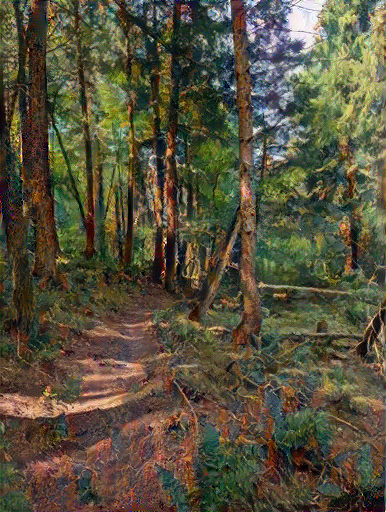

In [18]:
from PIL import Image
display(Image.open("/content/out.png"))

### Painterly stylization

**Goal**  
Create a stylized image that looks more like a painting: keep the overall composition while reducing fine photo detail and “sand” noise.

---

#### Hyperparameters
- `steps = 500` — number of optimization updates.
- `w_content = 1.0` — weight for **content loss** (keeps global structure).
- `w_style = 12.0` — weight for **style loss** (drives brush/texture/color).
- `w_tv = 5e-5` — weight for **total variation loss** (adds smoothness; suppresses speckle).

*Effect:* increase `w_style` → stronger style; increase `w_content` → more structure; increase `w_tv` → smoother, less noisy.

---

#### Style layers (which “style” features to match)
- We emphasize **mid/deep taps** (`relu3_1`, `relu4_1`) and down-weight **shallow taps** (`relu1_1`, `relu2_1`, `relu5_1`).
- *Why:* shallow layers tend to produce very fine, high-frequency textures; mid/deep taps encourage broader, painterly patterns.

---

#### Losses computed each step
- **Content loss (`Lc`)**: MSE between VGG features of the current image `X` and the content image at `CONTENT_LAYERS` → preserves overall arrangement.
- **Style loss (`Ls`)**: MSE between **Gram matrices** of `X` and the style image at `STYLE_LAYERS`, scaled by the per-layer weights → transfers multi-scale texture/brush/color statistics.
- **Total variation (`Ltv`)**: encourages neighboring pixels to be similar → reduces pixel-level noise.

---

#### Gaussian blur helper (`gauss_blur`)
- **Gaussian Blur:** An effect that smooths an image by applying a weighted average to each pixel based on its neighbors.
- **How it Works:** It uses a kernel, a small matrix of weights that slides over the image to define the blur. A Gaussian kernel's weights follow a bell curve, giving the most importance to the central pixel for a natural-looking effect.
- **Implementation:** This function builds a 1D kernel and applies it with two efficient, separable convolutions (vertical then horizontal).
- **Why used here:** By applying a very mild blur, it smooths out fine, pixel-level noise across the entire image while being too weak to significantly alter the large, coherent shapes.

---

#### Initialization
- Start `X` from a **mildly blurred** version of the content image plus **tiny noise**.
- *Why:* retains composition but softens sharp photo edges, making it easier to form paint-like regions rather than copying photographic detail.

---

#### Optimization loop (what happens each iteration)
1. Run `X` through **frozen VGG** to get tapped features.
2. Compute `Lc`, `Ls` (with the style layer weights), and `Ltv`.
3. Combine them into the total loss and use **Adam to update the pixels of `X`**.
4. Clamp `X` to `[0,1]` to keep valid image values.
5. Every 200 steps, apply a **very light blur** to reduce accumulating high-frequency noise.

---

#### Output
- Saves the final image to `/content/out_painterly.png`.

---

#### Quick tuning
- **Sharper / more structure:** slightly increase `w_content`, reduce or remove the periodic blur, or lower `w_tv`.
- **Looser / more painterly:** decrease `w_content`, increase `w_style`, or reduce shallow style layer weights further.
- **Less noise:** increase `w_tv` a bit or make the periodic blur slightly more frequent/stronger.

### Why there’s a Gaussian blur

**Purpose (what it’s for)**  
Lightly blur the working image `X` to suppress **tiny, high-frequency details** so optimization prefers **larger, paint-like regions** instead of gritty photo texture.

**What a kernel is (and why it’s odd-sized)**  
A *kernel* is a small sliding window of weights that averages each pixel with its neighbors.  
Odd sizes (3,5,7,…) give a single **center** that aligns with the pixel being updated.

**Gaussian blur = bell-curve averaging**  
- **Offsets `i`** = positions **relative to the pixel being updated**. If the kernel size is `k` (odd), let `r = (k-1)/2`. Then `i ∈ {-r, …, +r}` are the neighbors left/right (for a row) or up/down (for a column) of the **current pixel**.
- **Weights (bell curve):** for each offset `i`, compute an unnormalized weight  
  `w_tilde[i] = exp( - i^2 / (2 * sigma^2) )`.  
  Then **normalize** so they sum to 1 (keeps brightness):  
  `Z = sum_{j=-r}^{r} w_tilde[j]` and `w[i] = w_tilde[i] / Z`.
- **Applied to each pixel:** to blur one row at position `(m, n)` you replace the center value with a **weighted average of its neighbors**:  
  `X_hat[m, n] = sum_{i=-r}^{r} w[i] * X[m, n - i]`  (horizontal pass)  
  and similarly for a **vertical pass** over columns:  
  `Y[m, n] = sum_{i=-r}^{r} w[i] * X_hat[m - i, n]`.  
  (Two 1-D passes = full 2-D Gaussian blur, faster and equivalent.)
- **Intuition:** closer neighbors (small |i|) get larger weights → the pixel becomes a smooth average of its neighborhood, removing tiny high-frequency detail while preserving larger shapes.

**From 1-D to 2-D (separable, fast, same result)**  
2-D Gaussian kernel is the outer product: `K[i,j] = w[i] * w[j]`.  
Convolution can be done as two 1-D passes:  
• Vertical: `X_hat[m,n] = sum_{i=-r}^{r} w[i] * X[m-i, n]`  
• Horizontal: `Y[m,n] = sum_{j=-r}^{r} w[j] * X_hat[m, n-j]`

**How the function `gauss_blur` implements this**  
- Builds the 1-D Gaussian weights from `k` (kernel size) and `sigma` (spread) and **normalizes** them.  
- Applies **two depthwise convs**: vertical (`k×1`) then horizontal (`1×k`). *Depthwise* means each RGB channel is blurred **independently** (no color mixing).  
- Uses padding so the output stays the same size.

**How to tune (effect on sharpness)**  
- **Sharper (less blur):** smaller `sigma` (e.g., 0.6–1.0), smaller `k` (3–5), or call the blur less often.  
- **Softer (more blur):** larger `sigma`/`k`, or apply it more frequently.

**Bottom line**  
The Gaussian blur is a controlled low-pass filter: it dampens fine noise while keeping overall shapes, helping the style loss form coherent, painterly regions.

In [20]:
if not get_generated_images_from_drive:
  # Painterly result: keep forms, suppress photo detail & high-frequency texture
  import torch
  import torch.nn.functional as F

  # --- weights
  steps = 500
  w_content = 1.0
  w_style  = 12.0
  w_tv     = 5e-4

  # --- emphasize mid/deep style layers (coarser patterns), de-emphasize shallow (fine noise)
  style_layer_weights = {
      "relu1_1": 0.1,
      "relu2_1": 0.2,
      "relu3_1": 1.2,
      "relu4_1": 1.0,
      "relu5_1": 0.4,
  }

  def total_variation(x):
      tv_h = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
      tv_w = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
      return tv_h + tv_w

  def gauss_blur(x, k=7, sigma=2.0):
      # cheap separable Gaussian using conv; expects (1,3,H,W)
      import math
      radius = k // 2
      xs = torch.arange(-radius, radius+1, device=x.device, dtype=x.dtype)
      w = torch.exp(-0.5 * (xs / sigma) ** 2)
      w = (w / w.sum()).view(1, 1, -1)                # (1,1,k)
      # depthwise conv along H then W
      x = F.conv2d(x, w.unsqueeze(3).expand(3,1,-1,1), padding=(radius,0), groups=3)
      x = F.conv2d(x, w.unsqueeze(2).expand(3,1,1,-1), padding=(0,radius), groups=3)
      return x

  # --- init: blurred content + tiny noise (keeps composition, kills crisp detail)
  with torch.no_grad():
    X0 = gauss_blur(C, k=5, sigma=1.0)     # milder blur
    X0 = (X0 + 0.005 * torch.randn_like(X0)).clamp(0, 1)  # less noise
  X = X0.clone().requires_grad_(True)

  opt = torch.optim.Adam([X], lr=0.02)

  for t in range(1, steps + 1):
      opt.zero_grad()

      feats = vgg(X)

      # content loss (layout)
      Lc = sum(F.mse_loss(feats[n], content_targets[n]) for n in CONTENT_LAYERS)

      # style loss (multi-scale, weighted)
      Ls = 0.0
      for n in STYLE_LAYERS:
          Ls = Ls + style_layer_weights[n] * F.mse_loss(gram(feats[n]), style_targets[n])

      # smoothness
      Ltv = total_variation(X)

      loss = w_content*Lc + w_style*Ls + w_tv*Ltv
      loss.backward()
      opt.step()

      with torch.no_grad():
          # occasional light blur suppresses new high-freq noise while preserving forms
          if t % 200 == 0:
              X.copy_(gauss_blur(X, k=3, sigma=0.8).clamp(0,1))
          X.clamp_(0, 1)

      if t % 50 == 0 or t == steps:
          print(f"[{t}/{steps}] Lc={Lc.item():.3f}  Ls={Ls.item():.3f}  Ltv={Ltv.item():.6f}  Total={loss.item():.3f}")

  save_image(X, "/content/out_painterly.png")
  print("Saved: /content/out_painterly.png")

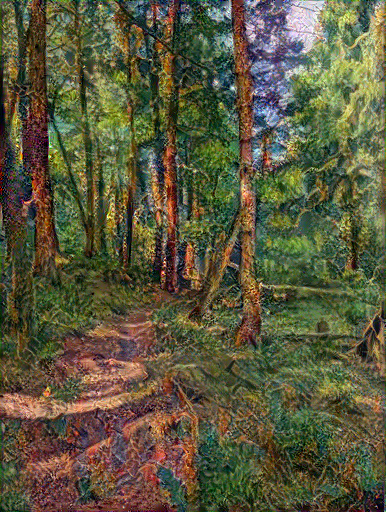

In [15]:
display(Image.open("/content/out_painterly.png"))

<h3><font color="#0b3d91">Enlarge output image</font></h3>

<h3><font color="#0b3d91">Smoothen out the image, add brush strokes</font></h3>

In [ ]:
# pip install -q opencv-contrib-python
import cv2, numpy as np

def oil_brush_balanced(
    in_path, out_path,
    brush_size=4, dyn_ratio=70, alpha=0.42,
    usm_radius=1.1, usm_amount=1.7,
    gamma=1.0,                  # 1.0 = no darkening; <1 brightens, >1 darkens
    pre_smooth=False,           # False keeps detail; True = bilateral pre-smooth
    add_edges=False, edge_weight=0.14, edge_low=90, edge_high=200
):
    img = cv2.imread(in_path, cv2.IMREAD_COLOR)
    if img is None: raise FileNotFoundError(in_path)

    base = cv2.bilateralFilter(img, 7, 30, 7) if pre_smooth else img

    # Oil-paint strokes
    oil = cv2.xphoto.oilPainting(base, brush_size, dyn_ratio)

    # Work in Lab (keep original a/b)
    lab_src = cv2.cvtColor(img,  cv2.COLOR_BGR2LAB)
    lab_oil = cv2.cvtColor(oil,  cv2.COLOR_BGR2LAB)
    Ls = lab_src[...,0].astype(np.float32)
    Lo = lab_oil[...,0].astype(np.float32)

    # Sharpen painted luminance
    blur = cv2.GaussianBlur(Lo, (0,0), usm_radius)
    Lo_sharp = (1.0 + usm_amount) * Lo - usm_amount * blur

    # Blend THEN tone-match to the original (prevents global darkening)
    Lmix = cv2.addWeighted(Lo_sharp, float(alpha), Ls, float(1.0 - alpha), 0.0, dtype=cv2.CV_32F)

    # --- replace the mean/std match with histogram matching ---
    def _hist_match_to_ref(src_f32, ref_f32):
        # map src luminance to have the same histogram as ref (both in 0..255)
        src_u8 = np.clip(src_f32, 0, 255).astype(np.uint8)
        ref_u8 = np.clip(ref_f32, 0, 255).astype(np.uint8)

        # CDFs
        src_hist = cv2.calcHist([src_u8], [0], None, [256], [0,256]).ravel()
        ref_hist = cv2.calcHist([ref_u8], [0], None, [256], [0,256]).ravel()
        src_cdf  = np.cumsum(src_hist) / (src_hist.sum() + 1e-6)
        ref_cdf  = np.cumsum(ref_hist) / (ref_hist.sum() + 1e-6)

        # For each src intensity, find ref intensity with closest CDF value
        mapping = np.interp(src_cdf, ref_cdf, np.arange(256))
        return mapping[src_u8].astype(np.float32)

    # After you compute Lmix (the blended L), do:
    Lmix = _hist_match_to_ref(Lmix, Ls)  # <-- replaces the mean/std normalization

    # Optional: darker edge reinforcement (subtle)
    if add_edges:
        e = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), edge_low, edge_high).astype(np.float32)
        e = cv2.GaussianBlur(e, (0,0), 0.8)
        Lmix = np.clip(Lmix - edge_weight * e, 0, 255)

    # Final gamma (1.0 = neutral)
    Lmix = np.clip(Lmix/255.0, 0, 1)
    Lmix = cv2.pow(Lmix, gamma) * 255.0
    Lmix_u8 = np.clip(Lmix, 0, 255).astype(np.uint8)

    lab_out = lab_src.copy()
    lab_out[...,0] = Lmix_u8
    out = cv2.cvtColor(lab_out, cv2.COLOR_LAB2BGR)
    cv2.imwrite(out_path, out)
    print("Saved:", out_path)

in_path  = "/content/out.png"
out_path = "/content/out_oil_natural.png"

oil_brush_balanced(
    in_path, out_path,
    brush_size=4, dyn_ratio=70, alpha=0.40,
    usm_radius=1.1, usm_amount=1.8,
    gamma=1.0,            # neutral; brightness controlled by hist match
    pre_smooth=False,     # keep detail
    add_edges=False
)

display(Image.open(out_path))

In [ ]:
im = Image.open(out_path)
w, h = im.size
print(f"Pixels: {w} × {h}")

for ppi in (300, 240, 200, 150):
    print(f"Max print at {ppi} PPI: {w/ppi:.2f} in × {h/ppi:.2f} in")